## Prompt:  

Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), can we build a model thatcan predict wether or nor a borrower will pay back their loan? This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan. Keep in mind classification metrics when evaluating the performance of your model!

`loan_status` is our label

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [4]:
# Load information relating to the features of our dataset
info_df = pd.read_csv('../../data/lending_club_info.csv', index_col='LoanStatNew')

In [5]:
info_df

,Description
LoanStatNew,
loan_amnt,The listed amount of the loan applied for by t...
term,The number of payments on the loan. Values are...
int_rate,Interest Rate on the loan
installment,The monthly payment owed by the borrower if th...
grade,LC assigned loan grade
sub_grade,LC assigned loan subgrade
emp_title,The job title supplied by the Borrower when ap...
emp_length,Employment length in years. Possible values ar...
home_ownership,The home ownership status provided by the borr...


In [6]:
print(info_df.loc['revol_util']['Description'])

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


In [7]:
def feat_info(col_name):
    print(info_df.loc[col_name]['Description'])

In [8]:
feat_info('grade')

LC assigned loan grade


## Load and Set-Up Data

In [9]:
df = pd.read_csv('../../data/lending_club_loan_two.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

## EDA  

### Investigate Target (`loan_status`)  

Look at the balance of the classes

<AxesSubplot:xlabel='loan_status', ylabel='count'>

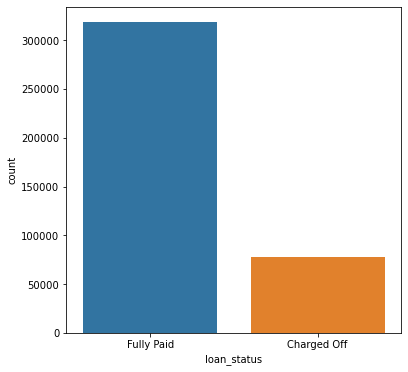

In [12]:
plt.figure(figsize=(6,6))
sns.countplot(x='loan_status', data=df)

We can expect our model to do well in terms of accuracy, so precision and recall will be our areas of evaluation.

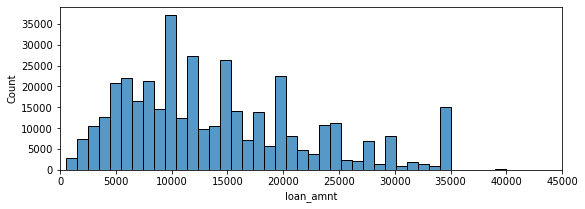

In [19]:
plt.figure(figsize=(9,3))
sns.histplot(df['loan_amnt'], kde=False, bins=40)
plt.xlim(0,45000);

### Correlation

In [22]:
df.corr()['loan_amnt'].sort_values()

pub_rec_bankruptcies   -0.106539
pub_rec                -0.077779
dti                     0.016636
revol_util              0.099911
int_rate                0.168921
open_acc                0.198556
mort_acc                0.222315
total_acc               0.223886
revol_bal               0.328320
annual_inc              0.336887
installment             0.953929
loan_amnt               1.000000
Name: loan_amnt, dtype: float64

In [23]:
df.corr()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
loan_amnt,1.000000,0.168921,0.953929,0.336887,0.016636,0.198556,-0.077779,0.328320,0.099911,0.223886,0.222315,-0.106539
int_rate,0.168921,1.000000,0.162758,-0.056771,0.079038,0.011649,0.060986,-0.011280,0.293659,-0.036404,-0.082583,0.057450
installment,0.953929,0.162758,1.000000,0.330381,0.015786,0.188973,-0.067892,0.316455,0.123915,0.202430,0.193694,-0.098628
annual_inc,0.336887,-0.056771,0.330381,1.000000,-0.081685,0.136150,-0.013720,0.299773,0.027871,0.193023,0.236320,-0.050162
dti,0.016636,0.079038,0.015786,-0.081685,1.000000,0.136181,-0.017639,0.063571,0.088375,0.102128,-0.025439,-0.014558
open_acc,0.198556,0.011649,0.188973,0.136150,0.136181,1.000000,-0.018392,0.221192,-0.131420,0.680728,0.109205,-0.027732
pub_rec,-0.077779,0.060986,-0.067892,-0.013720,-0.017639,-0.018392,1.000000,-0.101664,-0.075910,0.019723,0.011552,0.699408
revol_bal,0.328320,-0.011280,0.316455,0.299773,0.063571,0.221192,-0.101664,1.000000,0.226346,0.191616,0.194925,-0.124532
revol_util,0.099911,0.293659,0.123915,0.027871,0.088375,-0.131420,-0.075910,0.226346,1.000000,-0.104273,0.007514,-0.086751
total_acc,0.223886,-0.036404,0.202430,0.193023,0.102128,0.680728,0.019723,0.191616,-0.104273,1.000000,0.381072,0.042035


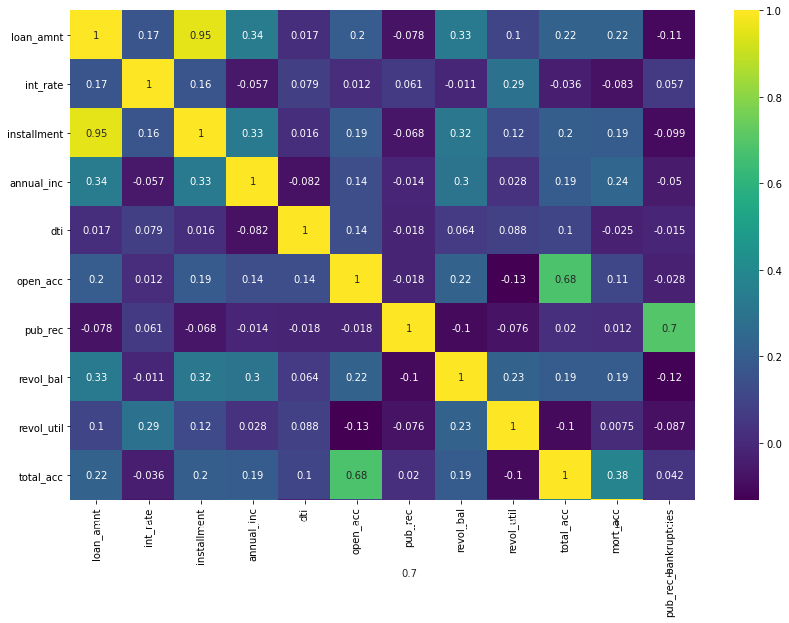

In [27]:
plt.figure(figsize=(14,9))
sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.ylim(10,0);

Our target has a near-perfect correlation with `installment`, let's look into that.

In [28]:
# What are the two features?
feat_info('installment')

The monthly payment owed by the borrower if the loan originates.


In [29]:
feat_info('loan_amnt')

The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
